In [6]:
import os
import time
import pathlib
import pickle
import tensorflow as tf

import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation,\
    Dropout, UpSampling2D, add, Conv2DTranspose
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:

inp_data_path = pathlib.Path('vangogh2photo/testA')
target_data_path = pathlib.Path('vangogh2photo/testB')
BATCH_SIZE =2
file_listA = [str(path) for path in inp_data_path.glob('*.jpg')]
file_listB = [str(path) for path in target_data_path.glob('*.jpg')]

print(file_listB[:4])

import cv2 

# preprocess data

def pre_img(path, name):
    
    d = len(path)
    data=np.empty((d,256,256,3))
    
    try:
        return pickle.load(open("{}.pkl".format(name), "rb")) 
        
    except:
        print("product array")
        for i, img in enumerate(path):
            
            img = cv2.imread(img) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

            img = (img - 127.5) / 127.5 # rescaling data (-1 ~ 1)
            data[i]=img 
        
        pickle.dump(data, open("{}.pkl".format(name), "wb"))
        
        return pickle.load(open("{}.pkl".format(name), "rb"))

# here I change the data order
 
data_b = pre_img(file_listA, "fileA")
data_a = pre_img(file_listB, "fileB")

image_generator = ImageDataGenerator(

    rotation_range = 5, 
    width_shift_range= 0.1,
    height_shift_range= 0.1,
    horizontal_flip=True,
    zoom_range= 0.1,
    fill_mode='nearest'
    
    )



train_data_a = image_generator.flow(data_a, batch_size=BATCH_SIZE)
train_data_b = image_generator.flow(data_b, batch_size=BATCH_SIZE)



['vangogh2photo/testB/2014-12-27 04:43:06.jpg', 'vangogh2photo/testB/2014-09-15 14:21:29.jpg', 'vangogh2photo/testB/2014-10-20 03:38:37.jpg', 'vangogh2photo/testB/2015-04-20 04:30:32.jpg']


In [9]:
class ReflectionPadding2D(tf.keras.layers.Layer):

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def conv_norm(inp_x, filter_size, kernel_size, strides=(1, 1), padding="same", active="relu"):
    
    if active=="leakyrelu":
        
        x = Conv2D(filter_size, kernel_size, strides, padding)(inp_x)
        x = tfa.layers.InstanceNormalization()(x)
        x = Activation('leaky_relu')(x)
        
        return x
        
    x = Conv2D(filter_size, kernel_size, strides, padding)(inp_x)
    x = tfa.layers.InstanceNormalization()(x)
    x = Activation('relu')(x)
        
    return x


def dconv_norm(inp_x, dim, kernel_size, strides=1, padding="same"):
    if strides == 1:
        
        x = Conv2DTranspose(dim, kernel_size, strides, padding)(inp_x)
        x = tfa.layers.InstanceNormalization()(x)
        x = Activation('relu')(x)
        
    else:
        x = UpSampling2D()(inp_x)
        x = Conv2D(dim, kernel_size, strides=1, padding="same")(x)
        x = tfa.layers.InstanceNormalization()(x)
        
        x = Activation('relu')(x)
        
    return x

def resBlock(inp_x, filter_size, kernel_size, dropout):
    
    x = ReflectionPadding2D()(inp_x)
    x = Conv2D(filter_size, kernel_size, strides=1, padding="valid")(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = Activation('relu')(x)

    x = ReflectionPadding2D()(x)
    x = Conv2D(filter_size, kernel_size, strides=1, padding="valid")(x)
    x = tfa.layers.InstanceNormalization()(x)
    
    x = Dropout(dropout)(x)
    out = add([x, inp_x])
        
    return out
    
    
    

        
        

In [10]:
# building model

class Generator():
    def __init__(self, inp_dim, conv_filter, dropout, n_block):
        
        self.inp_dim = inp_dim
        self.conv_filter = conv_filter
        self.dropout = dropout
        self.n_block = n_block
    
    def build(self):
        generator_inp = Input(self.inp_dim, name="generator_inp")
        
        x = ReflectionPadding2D((3,3))(generator_inp)
        x = conv_norm(x, self.conv_filter, kernel_size=7, strides=1, padding="valid")
        x = conv_norm(x, self.conv_filter*2, kernel_size=4, strides=2)
        x = conv_norm(x, self.conv_filter*4, kernel_size=4, strides=2)
        
        for _ in range(self.n_block):
            x = resBlock(x, self.conv_filter*4, kernel_size=3, dropout=self.dropout)
        
        x = dconv_norm(x, self.conv_filter*2, kernel_size=4, strides=2)
        x = dconv_norm(x, self.conv_filter, kernel_size=4, strides=2)
        
        x = ReflectionPadding2D((3,3))(x)
        x = Conv2D(3, kernel_size=7, strides=1, padding="valid")(x)
        x = Activation('tanh', name="tanh")(x)

        generator = Model(generator_inp, x)
        
        return generator
        
        
generator = Generator((256, 256, 3), 64, 0.5, 6).build()              
generator.summary()

print("-------------------------------")

class Discriminator():
    def __init__(self, inp_dim, conv_filter):
        
        self.inp_dim = inp_dim
        self.conv_filter = conv_filter
        
        
        
    def build(self):
        discriminator_inp = Input(self.inp_dim, name="discriminator_inp")
        x = Conv2D(self.conv_filter, kernel_size=1, strides=1, padding="same")(discriminator_inp)
        x = Activation('leaky_relu')(x)
        
        x = conv_norm(x, self.conv_filter*2, kernel_size=4, strides=2, active="leakyrelu")
        x = conv_norm(x, self.conv_filter*4, kernel_size=4, strides=2, active="leakyrelu")
        x = conv_norm(x, self.conv_filter*8, kernel_size=4, strides=1, active="leakyrelu")
        
        x = Conv2D(1, kernel_size=4, strides=1, padding="same")(x)
        
        discriminator = Model(discriminator_inp, x)
        
        return discriminator
    
discriminator = Discriminator((256, 256, 3), 64).build()
discriminator.summary()
        

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 generator_inp (InputLayer)     [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 reflection_padding2d_14 (Refle  (None, 262, 262, 3)  0          ['generator_inp[0][0]']          
 ctionPadding2D)                                                                                  
                                                                                                  
 conv2d_18 (Conv2D)             (None, 256, 256, 64  9472        ['reflection_padding2d_14[0][0]']
                                )                                                           

In [11]:
generatorA = Generator((256, 256, 3), 64, 0.5, 9).build()   
generatorB = Generator((256, 256, 3), 64, 0.5, 9).build() 
discriminatorA = Discriminator((256, 256, 3), 64).build()
discriminatorB = Discriminator((256, 256, 3), 64).build()


gen_A_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
gen_B_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_A_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_B_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

adv_loss_fn = tf.keras.losses.MeanSquaredError()

def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

# the following codes are from https://www.tensorflow.org/tutorials/generative/cyclegan
def train_step(data_a, data_b):
    
        lambda_cycle = 10.0
        lambda_identity = 0.5
        
        real_x, real_y = data_a, data_b
        
        cycle_loss_fn = tf.keras.losses.MeanAbsoluteError()
        identity_loss_fn = tf.keras.losses.MeanAbsoluteError()

        with tf.GradientTape(persistent=True) as tape:
            
            fake_y = generatorA(real_x)
            
            fake_x = generatorB(real_y, training=True)

            cycled_x = generatorB(fake_y, training=True)
            cycled_y = generatorA(fake_x, training=True)

            same_x = generatorB(real_x, training=True)
            same_y = generatorA(real_y, training=True)

            # Discriminator output
            disc_real_x = discriminatorA(real_x, training=True)
            disc_fake_x = discriminatorA(fake_x, training=True)

            disc_real_y = discriminatorB(real_y, training=True)
            disc_fake_y = discriminatorB(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = generator_loss_fn(disc_fake_y)
            gen_F_loss = generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = cycle_loss_fn(real_y, cycled_y) * lambda_cycle
            cycle_loss_F = cycle_loss_fn(real_x, cycled_x) * lambda_cycle

            # Generator identity loss
            id_loss_G = (
                identity_loss_fn(real_y, same_y)
                * lambda_cycle
                * lambda_identity
            )
            id_loss_F = (
                identity_loss_fn(real_x, same_x)
                * lambda_cycle
                * lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = discriminator_loss_fn(disc_real_y, disc_fake_y)

        grads_G = tape.gradient(total_loss_G, generatorA.trainable_variables)
        grads_F = tape.gradient(total_loss_F, generatorB.trainable_variables)

        disc_X_grads = tape.gradient(disc_X_loss, discriminatorA.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, discriminatorB.trainable_variables)

        gen_A_optimizer.apply_gradients(
            zip(grads_G, generatorA.trainable_variables)
        )
        gen_B_optimizer.apply_gradients(
            zip(grads_F, generatorB.trainable_variables)
        )

        disc_A_optimizer.apply_gradients(
            zip(disc_X_grads, discriminatorA.trainable_variables)
        )
        disc_B_optimizer.apply_gradients(
            zip(disc_Y_grads, discriminatorB.trainable_variables)
        )
        

In [12]:
def generate_and_save_images(epoch):
    
        _, ax = plt.subplots(4, 2, figsize=(12, 12))

        for i, img in enumerate(data_a[:4]):

            img = np.expand_dims(img, axis=0)
            prediction = generatorA(img)[0].numpy()

            prediction = (prediction + 1.0) * 127.5
            prediction = tf.cast(prediction, tf.uint8)

            img = (img + 1.0) * 127.5
            img = tf.cast(img, tf.uint8) 
            
            ax[i, 0].imshow(img[0])
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")
        
            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
               "picture/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        

In [13]:
CURRENT_EPOCH = 1
EPOCHs = 50
SAVE_EVERY_N_EPOCH = 2

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generatorA=generatorA,
                           generatorB=generatorB,
                           discriminatorA=discriminatorA,
                           discriminatorB=discriminatorB,
                           gen_A_optimizer=gen_A_optimizer,
                           gen_B_optimizer=gen_B_optimizer,
                           disc_A_optimizer=disc_A_optimizer,
                           disc_B_optimizer=disc_B_optimizer
                           )
                           

# save model

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))
    
    
for epoch in range(CURRENT_EPOCH, EPOCHs+1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    
    for step, (data_a, data_b) in enumerate(zip(train_data_a, train_data_b)):
        train_step(data_a, data_b)
        
        if (step + 1) % 50 == 0:
            print("-", end=" ")
        
        if step+1 >= 250:
            break
        
    
    generate_and_save_images(epoch)
    
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        #save model
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))

Latest checkpoint of epoch 52 restored!!


(532, 800, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

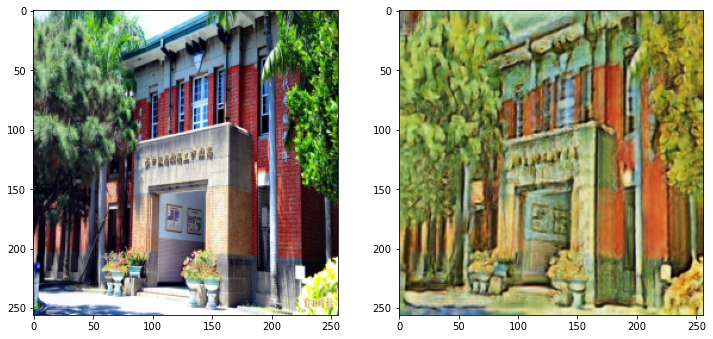

In [14]:
# model testing

img = cv2.imread("put your img path here") 
print(img.shape)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
img = (img - 127.5) / 127.5
img = np.expand_dims(img, axis=0)

prediction = generatorA(img)[0].numpy()
prediction = (prediction + 1.0) * 127.5
prediction = tf.cast(prediction, tf.uint8)

img = (img + 1.0) * 127.5
img = tf.cast(img, tf.uint8) 

_, ax = plt.subplots(1, 2, figsize=(12,12))

ax[0].imshow(img[0])
ax[1].imshow(prediction)


plt.show
#plt.savefig("pictur.jpg")


